# Pneumonia Detection from Chest X-ray through Deep Learning

## I. Overview

## II. Business Problem

## III. Data Understanding and Preparation
- The datasets acquired from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) were downloaded in a "chest_xray" folder. This folder has 3 sub-folders inside which are "train", "test", and "val". Each sub-folder contains 2 sub-folders: "NORMAL" and "PNEUMONIA"

In [1]:
import os

import pandas as pd
import numpy as np
# Set for displaying prediction probability for later
np.set_printoptions(precision=6, suppress=True)  # if absolute value < 1e-4, set equal to 0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from tensorflow import random
random.set_seed(24)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix

In [3]:
# Check the number of images in each sub-folders

# Train
train_normal = 'chest_xray/train/NORMAL'
train_pneumonia = 'chest_xray/train/PNEUMONIA'

print("Train Normal:", len(os.listdir(train_normal)))
print("Train Pneumonia:", len(os.listdir(train_pneumonia)))
print("Train Total:", len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia)))

# Test
test_normal = 'chest_xray/test/NORMAL'
test_pneumonia = 'chest_xray/test/PNEUMONIA'

print("\nTest Normal:", len(os.listdir(test_normal)))
print("Test Pneumonia:", len(os.listdir(test_pneumonia)))
print("Test Total:", len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia)))

# Validation
val_normal = 'chest_xray/val/NORMAL'
val_pneumonia = 'chest_xray/val/PNEUMONIA'

print("\nVal Normal:", len(os.listdir(val_normal)))
print("Val Pneumonia:", len(os.listdir(val_pneumonia)))
print("Val Total:", len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia)))

Train Normal: 1341
Train Pneumonia: 3875
Train Total: 5216

Test Normal: 234
Test Pneumonia: 390
Test Total: 624

Val Normal: 8
Val Pneumonia: 8
Val Total: 16


In [4]:
# Create file directory
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

In [5]:
# Create data generator
# Get all the train data (5216), test data (624), validation data (16) in the corresponding directory
# Scale data
# Set each image to 128×128 px
# Set binary class mode

train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216, class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624, class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16, class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
# Create the data sets
# next - retrieve the next item from iterator
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [7]:
# Check the shape
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))

print ("\nX_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

print ("\nX_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

X_train shape: (5216, 128, 128, 3)
y_train shape: (5216,)

X_test shape: (624, 128, 128, 3)
y_test shape: (624,)

X_val shape: (16, 128, 128, 3)
y_val shape: (16,)


In [8]:
# Check if the binary indicator was correctly labeled
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

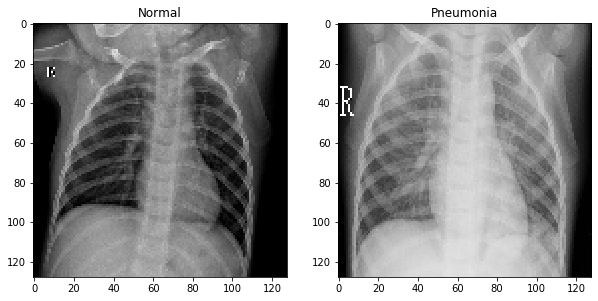

In [9]:
# Preview the chest x-ray
fig = plt.figure(figsize=(10,10))

# Normal
ax1 = fig.add_subplot(121)
plt.imshow(X_val[3])
if y_val[3] == 1:
    plt.title("Pneumonia")
else:
    plt.title("Normal")

# Pneumonia        
ax2 = fig.add_subplot(122)
plt.imshow(X_val[1])
if y_val[1] == 1:
    plt.title("Pneumonia")
else:
    plt.title("Normal")

In [10]:
def visualize_training_results(history):
    '''
    Input: keras history object 
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [11]:
def model_evaluation(model):
    '''
    Input: keras model
    
    Append accuracy results
    
    Plot confusion matrix
    '''
    
    train_acc = []
    test_acc = []
    
    # Train loss and accuracy
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    train_acc.append(round(result_train[1], 4))
    
    # Test loss and accuracy
    result_test = model.evaluate(X_test, y_test)
    print(f'Test Loss:{result_test[0]:.4}')
    print(f'Test Accuracy:{result_test[1]:.4}')
    test_acc.append(round(result_test[1], 4))
    
    # Prediction
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    ax.set_ylim(2,0)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    
    return train_acc, test_acc

### Note:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step
- <u>*validation set*</u> will be used as true holdout which only use at the end 

### Problem of small validation set
- If the validation set contains much less data than training set, the validation curves (accuracy and loss) will be spiky before convergence. In other words, more epochs and longer training time will be required

## IV. Modeling

### CNN Baseline Model

In [12]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [13]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 44s 267ms/step - loss: 0.4309 - accuracy: 0.8076 - val_loss: 1.0070 - val_accuracy: 0.6955
Epoch 2/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0984 - accuracy: 0.9634 - val_loss: 0.6370 - val_accuracy: 0.7788
Epoch 3/50
163/163 [==============================] - 42s 260ms/step - loss: 0.0815 - accuracy: 0.9737 - val_loss: 0.7579 - val_accuracy: 0.7788
Epoch 4/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0730 - accuracy: 0.9707 - val_loss: 1.4351 - val_accuracy: 0.6955
Epoch 5/50
163/163 [==============================] - 42s 260ms/step - loss: 0.0738 - accuracy: 0.9740 - val_loss: 0.9536 - val_accuracy: 0.7788
Epoch 6/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0471 - accuracy: 0.9833 - val_loss: 1.5497 - val_accuracy: 0.7308
Epoch 7/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0390 - accuracy: 0.9855 - val_loss: 2.0710 - val_ac

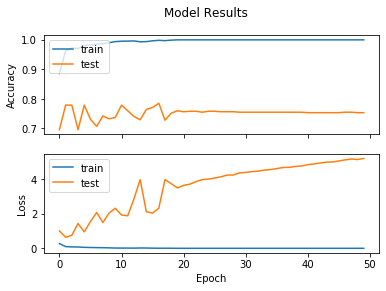

In [14]:
visualize_training_results(base_history)

In [15]:
base_model.save('saved_models/base_model.h5')

163/163 [==============================] - 11s 67ms/step - loss: 1.2462e-06 - accuracy: 1.0000
Training Loss:1.246e-06
Training Accuracy:1.0
20/20 [==============================] - 1s 68ms/step - loss: 5.2010 - accuracy: 0.7532
Test Loss:5.201
Test Accuracy:0.7532


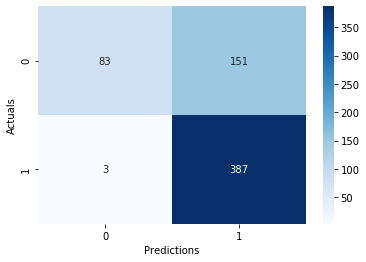

([1.0], [0.7532])

In [31]:
base = load_model('saved_models/base_model.h5')
model_evaluation(base)

>**Comment:** *Baseline Model*
- The CNN baseline model took more than 40 minutes to run
- The train accuracy (100%) is higher than val accuracy (0.753) which indicates that the baseline model is overfit
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
- Early stopping can be used for iteration model tunning to prevent overfit and saving time
- There are more false positive than false negative

### Dropout 20
- Add (20%) dropout layers and earlystopping 

In [32]:
dropout_20 = models.Sequential()
dropout_20.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Flatten())
dropout_20.add(layers.Dense(128, activation='relu'))
dropout_20.add(layers.Dense(1, activation='sigmoid'))

dropout_20.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [33]:
es_dp_20 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='saved_models/best_dropout_20.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [34]:
dropout_20_history = dropout_20.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    callbacks=es_dp_20,
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 50s 307ms/step - loss: 0.6226 - accuracy: 0.7624 - val_loss: 0.6808 - val_accuracy: 0.7644

Epoch 00001: val_accuracy improved from -inf to 0.76442, saving model to saved_models/best_dropout_20.h5
Epoch 2/50
163/163 [==============================] - 50s 304ms/step - loss: 0.1236 - accuracy: 0.9561 - val_loss: 0.4815 - val_accuracy: 0.7997

Epoch 00002: val_accuracy improved from 0.76442 to 0.79968, saving model to saved_models/best_dropout_20.h5
Epoch 3/50
163/163 [==============================] - 46s 284ms/step - loss: 0.1147 - accuracy: 0.9558 - val_loss: 0.6525 - val_accuracy: 0.7885

Epoch 00003: val_accuracy did not improve from 0.79968
Epoch 4/50
163/163 [==============================] - 46s 283ms/step - loss: 0.0994 - accuracy: 0.9635 - val_loss: 1.2538 - val_accuracy: 0.7388

Epoch 00004: val_accuracy did not improve from 0.79968
Epoch 5/50
163/163 [==============================] - 46s 281ms/step - loss: 0.0867 - accurac

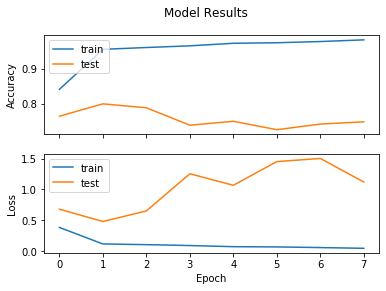

In [35]:
visualize_training_results(dropout_20_history)

163/163 [==============================] - 11s 64ms/step - loss: 0.1166 - accuracy: 0.9659
Training Loss:0.1166
Training Accuracy:0.9659
20/20 [==============================] - 2s 75ms/step - loss: 0.4815 - accuracy: 0.7997
Test Loss:0.4815
Test Accuracy:0.7997


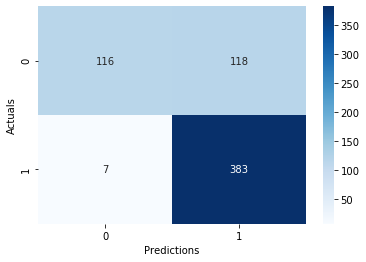

([0.9659], [0.7997])

In [36]:
dp20 = load_model('saved_models/best_dropout_20.h5')
model_evaluation(dp20)

>**Comment:** Dropout 20%
- The dropout_20 model took less time to run compare with the baseline model
- The train accuracy (0.9659) is higher than test accuracy (0.7997) which indicates the model is overfit 
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative
- dp20 has more FN than base

#### Dropout 20b

In [11]:
dropout_20b = models.Sequential()
dropout_20b.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Flatten())
dropout_20b.add(layers.Dense(128, activation='relu'))
dropout_20b.add(layers.Dropout(0.2))
dropout_20b.add(layers.Dense(1, activation='sigmoid'))

dropout_20b.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [12]:
es_dp_20b = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='best_dropout_20b.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]  

In [13]:
dropout_20b_history = dropout_20b.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_20b,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 48s 293ms/step - loss: 0.5207 - accuracy: 0.7878 - val_loss: 0.7091 - val_accuracy: 0.7260

Epoch 00001: val_accuracy improved from -inf to 0.72596, saving model to best_dropout_20b.h5
Epoch 2/50
163/163 [==============================] - 47s 287ms/step - loss: 0.1186 - accuracy: 0.9572 - val_loss: 0.5289 - val_accuracy: 0.7885

Epoch 00002: val_accuracy improved from 0.72596 to 0.78846, saving model to best_dropout_20b.h5
Epoch 3/50
163/163 [==============================] - 47s 288ms/step - loss: 0.1032 - accuracy: 0.9669 - val_loss: 0.7739 - val_accuracy: 0.7404

Epoch 00003: val_accuracy did not improve from 0.78846
Epoch 4/50
163/163 [==============================] - 47s 287ms/step - loss: 0.0949 - accuracy: 0.9670 - val_loss: 0.7697 - val_accuracy: 0.7804

Epoch 00004: val_accuracy did not improve from 0.78846
Epoch 5/50
163/163 [==============================] - 47s 287ms/step - loss: 0.0672 - accuracy: 0.9758 - val_loss: 0.

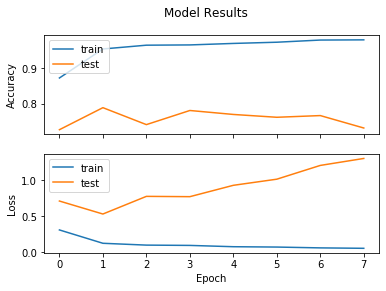

In [14]:
visualize_training_results(dropout_20b_history)

In [15]:
dp20b = load_model('best_dropout_20b.h5')
model_evaluation(dp20b)

163/163 [==============================] - 11s 66ms/step - loss: 0.1055 - accuracy: 0.9680
Training Loss:0.1055
Training Accuracy:0.968
1/1 [==============================] - 0s 130ms/step - loss: 0.3069 - accuracy: 0.8125
Val Loss:0.3069
Val Accuracy:0.8125


### Dropout 50
- Add (50%) dropout layer and earlystopping

In [37]:
dropout_50 = models.Sequential()
dropout_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Flatten())
dropout_50.add(layers.Dense(128, activation='relu'))
dropout_50.add(layers.Dense(1, activation='sigmoid'))

dropout_50.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [38]:
es_dp_50 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='saved_models/best_dropout_50.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [39]:
dropout_50_history = dropout_50.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_50,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 48s 292ms/step - loss: 1.0002 - accuracy: 0.6767 - val_loss: 0.4933 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to saved_models/best_dropout_50.h5
Epoch 2/50
163/163 [==============================] - 50s 308ms/step - loss: 0.3354 - accuracy: 0.8167 - val_loss: 0.5553 - val_accuracy: 0.6474

Epoch 00002: val_accuracy improved from 0.62500 to 0.64744, saving model to saved_models/best_dropout_50.h5
Epoch 3/50
163/163 [==============================] - 47s 290ms/step - loss: 0.2649 - accuracy: 0.9223 - val_loss: 0.4720 - val_accuracy: 0.7628

Epoch 00003: val_accuracy improved from 0.64744 to 0.76282, saving model to saved_models/best_dropout_50.h5
Epoch 4/50
163/163 [==============================] - 48s 292ms/step - loss: 0.2340 - accuracy: 0.9359 - val_loss: 0.6679 - val_accuracy: 0.7099

Epoch 00004: val_accuracy did not improve from 0.76282
Epoch 5/50
163/163 [====================

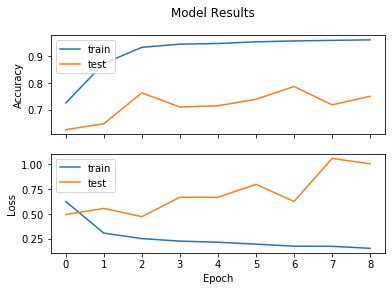

In [40]:
visualize_training_results(dropout_50_history)

163/163 [==============================] - 11s 65ms/step - loss: 0.1660 - accuracy: 0.9709
Training Loss:0.166
Training Accuracy:0.9709
20/20 [==============================] - 1s 68ms/step - loss: 0.6248 - accuracy: 0.7869
Test Loss:0.6248
Test Accuracy:0.7869


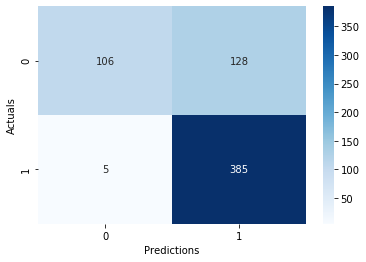

([0.9709], [0.7869])

In [41]:
dp50 = load_model('saved_models/best_dropout_50.h5')
model_evaluation(dp50)

>**Comment:**
- The dropout_50 model took less time to run compare with the baseline model
- The train accuracy (0.9709) is higher than test accuracy (0.7869) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- Compare with dp20, test accuracy is slightly lower
    Decrease the complexity => lose some useful information?
- There are more false positive than false negative

### L2 Regularizer

https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

In [42]:
L2_reg = models.Sequential()
L2_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(128,128,3)))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Flatten())
L2_reg.add(layers.Dense(128, activation='relu'))
L2_reg.add(layers.Dense(1, activation='sigmoid'))

L2_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [43]:
es_L2 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='saved_models/best_L2.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [44]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es_L2,
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 42s 257ms/step - loss: 0.8745 - accuracy: 0.7786 - val_loss: 0.9707 - val_accuracy: 0.6683

Epoch 00001: val_accuracy improved from -inf to 0.66827, saving model to saved_models/best_L2.h5
Epoch 2/50
163/163 [==============================] - 42s 259ms/step - loss: 0.2809 - accuracy: 0.9524 - val_loss: 0.5034 - val_accuracy: 0.8446

Epoch 00002: val_accuracy improved from 0.66827 to 0.84455, saving model to saved_models/best_L2.h5
Epoch 3/50
163/163 [==============================] - 42s 260ms/step - loss: 0.1937 - accuracy: 0.9637 - val_loss: 0.7715 - val_accuracy: 0.7901

Epoch 00003: val_accuracy did not improve from 0.84455
Epoch 4/50
163/163 [==============================] - 43s 261ms/step - loss: 0.1605 - accuracy: 0.9641 - val_loss: 1.1403 - val_accuracy: 0.7404

Epoch 00004: val_accuracy did not improve from 0.84455
Epoch 5/50
163/163 [==============================] - 43s 261ms/step - loss: 0.1460 - accuracy: 0.9695 - val_

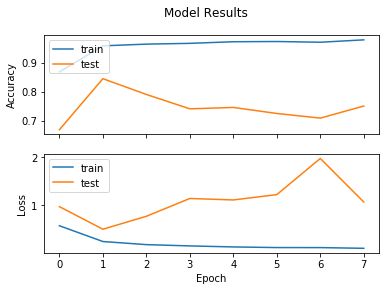

In [45]:
visualize_training_results(L2_reg_history)

163/163 [==============================] - 11s 67ms/step - loss: 0.2492 - accuracy: 0.9442
Training Loss:0.2492
Training Accuracy:0.9442
20/20 [==============================] - 2s 69ms/step - loss: 0.5034 - accuracy: 0.8446
Test Loss:0.5034
Test Accuracy:0.8446


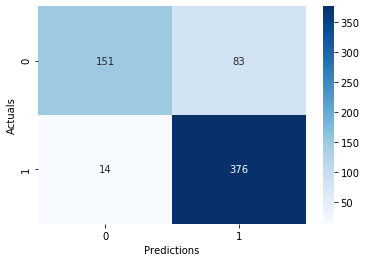

([0.9442], [0.8446])

In [46]:
L2 = load_model('saved_models/best_L2.h5')
model_evaluation(L2)

>**Comment:** 
- The L2 took less time to run compare with the baseline model
- The train accuracy (0.9442) is higher than test accuracy (0.8446) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

#### L2_01

In [16]:
L2_01 = models.Sequential()
L2_01.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(128,128,3)))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Flatten())
L2_01.add(layers.Dense(128, activation='relu'))
L2_01.add(layers.Dense(1, activation='sigmoid'))

L2_01.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [17]:
es_L2_01 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_L2_01.h5', 
                                    monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [18]:
L2_01_history = L2_01.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_L2_01,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 261ms/step - loss: 1.1511 - accuracy: 0.7802 - val_loss: 0.8041 - val_accuracy: 0.7612

Epoch 00001: val_accuracy improved from -inf to 0.76122, saving model to best_L2_01.h5
Epoch 2/50
163/163 [==============================] - 43s 266ms/step - loss: 0.2782 - accuracy: 0.9547 - val_loss: 0.6924 - val_accuracy: 0.7692

Epoch 00002: val_accuracy improved from 0.76122 to 0.76923, saving model to best_L2_01.h5
Epoch 3/50
163/163 [==============================] - 43s 263ms/step - loss: 0.2047 - accuracy: 0.9644 - val_loss: 0.7289 - val_accuracy: 0.7885

Epoch 00003: val_accuracy improved from 0.76923 to 0.78846, saving model to best_L2_01.h5
Epoch 4/50
163/163 [==============================] - 46s 280ms/step - loss: 0.1814 - accuracy: 0.9639 - val_loss: 0.7634 - val_accuracy: 0.7628

Epoch 00004: val_accuracy did not improve from 0.78846
Epoch 5/50
163/163 [==============================] - 46s 284ms/step - loss: 0.1462 - accuracy

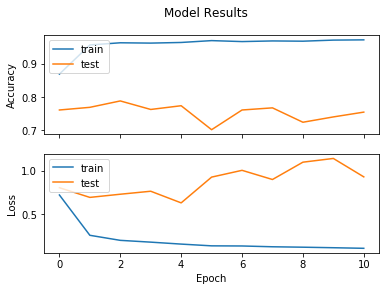

In [19]:
visualize_training_results(L2_01_history)

In [20]:
L201 = load_model('best_L2_01.h5')
model_evaluation(L201)

163/163 [==============================] - 11s 70ms/step - loss: 0.1782 - accuracy: 0.9615
Training Loss:0.1782
Training Accuracy:0.9615
1/1 [==============================] - 0s 142ms/step - loss: 0.2084 - accuracy: 1.0000
Val Loss:0.2084
Val Accuracy:1.0


#### L2(0.005) prediction TRY

163/163 [==============================] - 11s 64ms/step - loss: 0.2492 - accuracy: 0.9442
Training Loss:0.2492
Training Accuracy:0.9442
20/20 [==============================] - 2s 64ms/step - loss: 0.5034 - accuracy: 0.8446
Test Loss:0.5034
Test Accuracy:0.8446


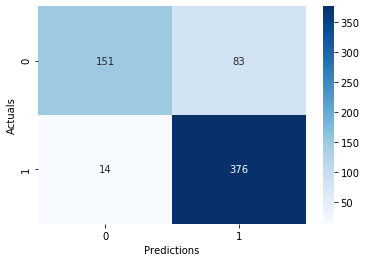

([0.9442], [0.8446])

In [45]:
L2 = load_model('saved_models/best_L2.h5')
model_evaluation(L2)

In [46]:
# Predict for probability of getting 1
L2.predict(X_val)

# predict_proba was deprecated

array([[0.33516 ],
       [0.758586],
       [0.917087],
       [0.022783],
       [0.994851],
       [0.096325],
       [0.827329],
       [0.985   ],
       [0.020615],
       [0.097032],
       [0.082617],
       [0.134354],
       [0.387113],
       [0.03226 ],
       [0.99537 ],
       [0.924776]], dtype=float32)

In [47]:
# Flatten the array
prob = L2.predict(X_val).flatten()
prob

array([0.33516 , 0.758586, 0.917087, 0.022783, 0.994851, 0.096325,
       0.827329, 0.985   , 0.020615, 0.097032, 0.082617, 0.134354,
       0.387113, 0.03226 , 0.99537 , 0.924776], dtype=float32)

In [48]:
# Make prediction 
y_val_pred = ((L2.predict(X_val) > 0.5).astype("int32")).flatten()
y_val_pred

# pad.predict_classes(X_val) was deprecated

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [49]:
y_act = y_val.astype("int32").flatten()
y_act

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [50]:
compare_df = pd.concat([pd.Series(y_act, name="Actual"),
                        pd.Series(y_val_pred, name="Predicted"),
                        pd.Series(prob, name="Probabilities")], axis=1)

In [51]:
compare_df

,Actual,Predicted,Probabilities
0,0,0,0.335160
1,1,1,0.758586
2,1,1,0.917087
3,0,0,0.022783
4,1,1,0.994851
5,0,0,0.096325
6,1,1,0.827329
7,1,1,0.985000
8,0,0,0.020615
9,0,0,0.097032


### Padding

In [47]:
padding = models.Sequential()
padding.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128,128,3)))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Flatten())
padding.add(layers.Dense(128, activation='relu'))
padding.add(layers.Dense(1, activation='sigmoid'))

padding.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [48]:
es_padding = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
              ModelCheckpoint(filepath='saved_models/best_padding.h5', 
                              monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [49]:
padding_history = padding.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              callbacks=es_padding,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 50s 302ms/step - loss: 0.5563 - accuracy: 0.7632 - val_loss: 0.9447 - val_accuracy: 0.7244

Epoch 00001: val_accuracy improved from -inf to 0.72436, saving model to saved_models/best_padding.h5
Epoch 2/50
163/163 [==============================] - 47s 287ms/step - loss: 0.1118 - accuracy: 0.9594 - val_loss: 0.8752 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.72436 to 0.75641, saving model to saved_models/best_padding.h5
Epoch 3/50
163/163 [==============================] - 47s 289ms/step - loss: 0.0956 - accuracy: 0.9680 - val_loss: 0.7980 - val_accuracy: 0.7804

Epoch 00003: val_accuracy improved from 0.75641 to 0.78045, saving model to saved_models/best_padding.h5
Epoch 4/50
163/163 [==============================] - 47s 288ms/step - loss: 0.0781 - accuracy: 0.9728 - val_loss: 1.6736 - val_accuracy: 0.6971

Epoch 00004: val_accuracy did not improve from 0.78045
Epoch 5/50
163/163 [=============================

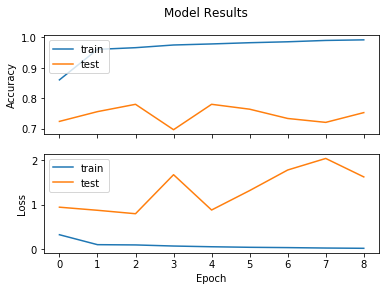

In [50]:
visualize_training_results(padding_history)

163/163 [==============================] - 12s 74ms/step - loss: 0.0582 - accuracy: 0.9785
Training Loss:0.05816
Training Accuracy:0.9785
20/20 [==============================] - 2s 74ms/step - loss: 0.7980 - accuracy: 0.7804
Test Loss:0.798
Test Accuracy:0.7804


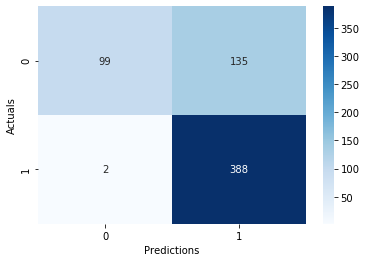

([0.9785], [0.7804])

In [51]:
pad = load_model('saved_models/best_padding.h5')
model_evaluation(pad)

>**Comment:** 
- The Padding took less time to run compare with the baseline model
- The train accuracy (0.9785) is higher than test accuracy (0.7804) which indicates the model is overfit
- Compare with the baseline model, test accuray shows some improvements
- There are more false positive than false negative

### Pretrained VGG19

In [12]:
from keras.applications import VGG19

In [38]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=X_train.shape[1:])

In [39]:
pre = models.Sequential()
pre.add(pretrained)
pre.add(layers.Flatten())
pre.add(layers.Dense(128, activation='relu'))
pre.add(layers.Dense(1, activation='sigmoid'))

# Freeze pretained layer
pretrained.trainable = False

In [40]:
pre.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [41]:
# Verify "frozen"
for layer in pre.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_3 True
dense_6 True
dense_7 True


In [42]:
pre.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [43]:
es_pre = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
          ModelCheckpoint(filepath='saved_models/best_pre.h5', 
                          monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [ ]:
pre_history = pre.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      callbacks=es_pre,
                      validation_data=(X_test, y_test))

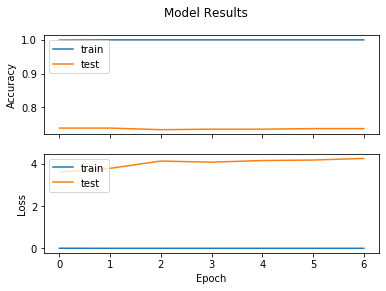

In [79]:
visualize_training_results(pre_history)

163/163 [==============================] - 11s 68ms/step - loss: 1.9432e-04 - accuracy: 1.0000
Training Loss:0.000194323
Training Accuracy:1.0
1/1 [==============================] - 0s 135ms/step - loss: 0.1564 - accuracy: 0.8750
Val Loss:0.156365
Val Accuracy:0.875


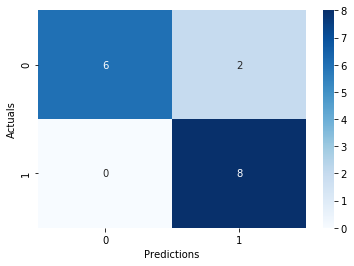

([1.0], [0.875])

In [145]:
pret = load_model('saved_models/best_pre.h5')
model_evaluation(pret)

In [98]:
y_val_pred = (xx2.predict(X_val) > 0.5).astype("int32")
y_val_pred

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1]], dtype=int32)

In [99]:
y_val

array([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [100]:
from sklearn.metrics import confusion_matrix

In [106]:
import seaborn as sns

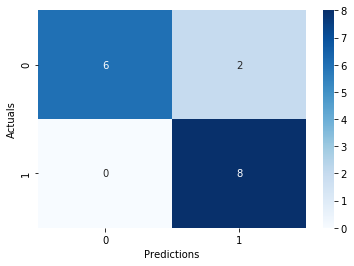

In [120]:
cm = confusion_matrix(y_val, y_val_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_ylim(2,0)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

In [126]:
rs = xx2.evaluate(X_val, y_val)
rs

1/1 [==============================] - 0s 52ms/step - loss: 0.1564 - accuracy: 0.8750


[0.15636546909809113, 0.875]

In [132]:
rs[1]

0.875

In [133]:
valacc = []

In [140]:
valacc.append(xx2.evaluate(X_val, y_val)[1])

1/1 [==============================] - 0s 50ms/step - loss: 0.1564 - accuracy: 0.8750


In [141]:
valacc

[0.875]